توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
# download data
%%capture
import os

if len(os.listdir()) < 3:
  !wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
  !wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
  !unzip ADEChallengeData2016.zip
  !unzip release_test.zip
!pip install mmengine

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
from tqdm import tqdm

from cv2 import imread as IM
from os import path

from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
import gc
gc.collect()

78

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# function 1
def displacement(img):
  # Get image dimensions
  (height, width) = img.shape[:2]
  random_choice = np.random.choice([-1, 1],size=2)
  dx , dy= np.random.randint(25,50,size= 2)
  dx *= random_choice[0]
  dy *= random_choice[1]
  M = np.float32([[1, 0, dx], [0, 1, dy]])
  displaced_img = cv2.warpAffine(img, M, (width, height),borderMode=cv2.BORDER_REPLICATE)
  img = cv2.resize(displaced_img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 2
def rotation(img):
  (h, w) = img.shape[:2]
  center = (w // 2, h // 2)
  random_choice = np.random.choice([-1, 1])
  degree = np.random.randint(20,40)
  M = cv2.getRotationMatrix2D(center, random_choice*degree, 1)
  img = cv2.warpAffine(img, M, (w, h),borderMode=cv2.BORDER_REPLICATE)
  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 3
def scaling(img):
  original_height , original_width = (224,224)
  scalef = np.random.randint(0,2)
  val = np.random.randint(2,4)
  if scalef == 1 :
    original_height, original_width = img.shape[:2]
    width = original_width * val
    height = original_height * val
    new_dimensions = (width, height)
    img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_LINEAR)
    center = (width//2,height//2)
    img = img[center[0]-112 : center[0] + 112 , center[1]-112 : center[1] + 112]

  else :
    width =  original_width // val
    height = original_height // val
    new_dimensions = (width, height)
    img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_LINEAR)

  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 4
def Brightness(img):  ## for augmentation
  BorD = random.randn(-1,1)
  adjusted = cv2.convertScaleAbs(img, beta= BorD * 120)
  img = cv2.resize(adjusted, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 5
def bluring(img):# for augmentation
  image = cv2.blur(img, (10,20))
  img = cv2.resize(image, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 6
def gaussian_noise(img):#for augmentation
  # Generate a matrix of random values with a Gaussian distribution
  mean = 100
  stddev = 150
  noise = np.zeros(img.shape, np.uint8)
  cv2.randn(noise, mean, stddev)
  noisy_img = cv2.add(img, noise)
  img = cv2.resize(noisy_img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img


### in the constructor of the dataset we need to append the path of the pictures to data list. in __getitem__ function we have the path of each data that we get from index 'idx' and we should do the desired and random transformations to that picture. in the end we returned the tranformed pic , original pic and its lables in different shapes (vector and decimal). the the is a binary vector that each of its elements represents a special change for example __[1,1,0]__ says this pic (self.data[idx]) has been displaced and rotated. also we use the decimal representation of change vector in order to better understadning the loss and accuracy calculation during training phase.

In [4]:
def vectoClass(vec):
    output = 0
    for i,digit in enumerate(vec) :
      output += digit * (2**i)
    return output

class CustomDataset(Dataset):
    def __init__(self, root, split='training', transform=None):
        self.root = root
        self.transform = transform
        self.data = []
        self.split = split
        path = os.path.join(self.root,self.split)

        for _,_,fnames in os.walk(path):
            for fname in fnames :
                froot = os.path.join(path,fname)
                self.data.append(froot)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img_orgin = IM(img_path)
        img_resized = cv2.resize(img_orgin, (224, 224))
        functions = [displacement, rotation, scaling]
        Aug_functions = [Brightness, bluring, gaussian_noise]
        change_vec = np.zeros(3)

        rand_num = random.randint(1,3)
        # origin_change_vec = np.random.randint(2, size=3)

        img_buff = img_resized
        for i in range(rand_num) :
            func = random.sample(functions,1)[0]
            img_buff = func(img_buff)
            change_vec[functions.index(func)] = 1
        changed_img = img_buff

        if self.transform != None:
            changed_img = self.transform(changed_img)
            img_resized = self.transform(img_resized)

        img_resized = (torch.Tensor(img_resized).permute(2, 0, 1)).numpy()
        changed_img = (torch.Tensor(changed_img).permute(2, 0, 1)).numpy()
        return img_resized, changed_img, torch.from_numpy(change_vec), vectoClass(change_vec)

    def __len__(self):
        return len(self.data)



In [5]:
dataset_train = CustomDataset(root='./ADEChallengeData2016/images/',split='training')
dataset_test = CustomDataset(root='./ADEChallengeData2016/images/',split='validation')
dataset_val = CustomDataset(root='./release_test/',split='testing')

train_loader = DataLoader(dataset=dataset_train,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=dataset_test,batch_size=32,shuffle=False)
valid_loader = DataLoader(dataset=dataset_val,batch_size=32,shuffle=True)


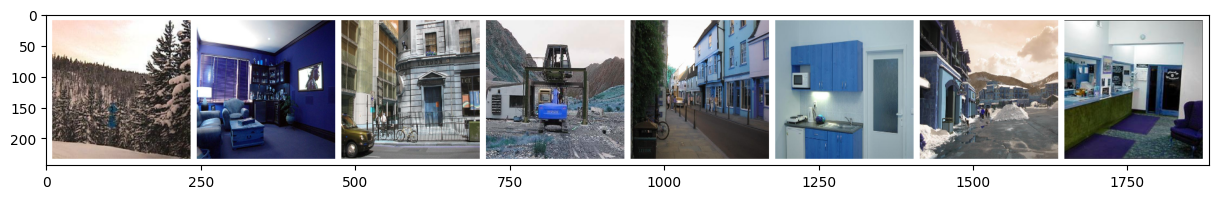

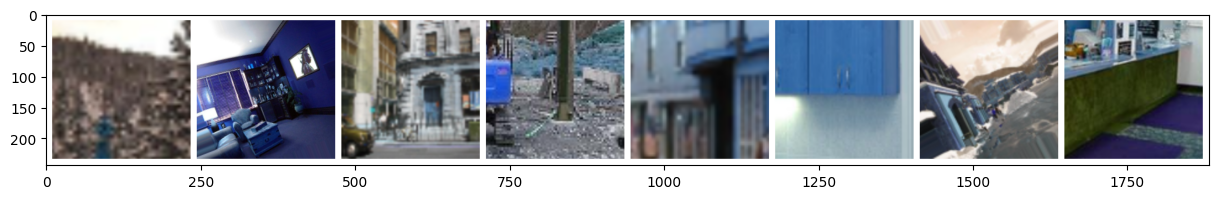

the changed vectors are :{displacement,rotation,scaling}
vec0: tensor([0., 0., 1.], dtype=torch.float64) , 4.0 	
vec1: tensor([0., 1., 0.], dtype=torch.float64) , 2.0 	
vec2: tensor([0., 0., 1.], dtype=torch.float64) , 4.0 	
vec3: tensor([1., 0., 1.], dtype=torch.float64) , 5.0 	
vec4: tensor([0., 0., 1.], dtype=torch.float64) , 4.0 	
vec5: tensor([0., 0., 1.], dtype=torch.float64) , 4.0 	
vec6: tensor([0., 1., 1.], dtype=torch.float64) , 6.0 	
vec7: tensor([1., 0., 1.], dtype=torch.float64) , 5.0 	


In [6]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
def imshow(img , vecs= None , labels=None):
    npimg = img.numpy()
    img_n = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(15,15))
    plt.imshow(img_n.astype('uint8'))
    plt.show()
    if vecs is not None :
        print('the changed vectors are :{displacement,rotation,scaling}')
        for i,vec in enumerate(vecs) :
            print(f'vec{i}: {vec} , {labels[i]} \t')

for origin_img, changed_img, label_vec , labels in train_loader :
    o_images = make_grid(origin_img[0:8,:,:,:],padding=10,pad_value=255)
    c_images = make_grid(changed_img[0:8,:,:,:],padding=10,pad_value=255)
    imshow(o_images)
    imshow(c_images,label_vec[0:8,:],labels[0:8])
    break


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

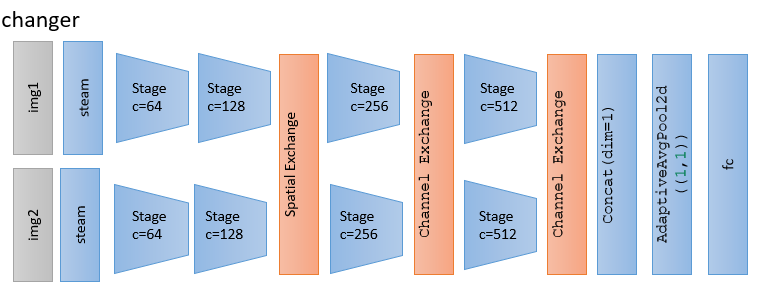

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


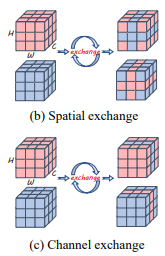

In [7]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

SpatialExchange1 = SpatialExchange(p=0.2)


شبکه ی زیر را پیاده کنید  

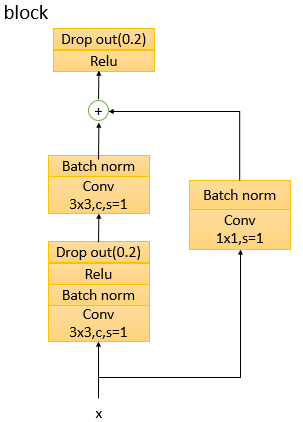

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)

 padding = 0 , channel out size : برابر با تعداد چنل خروجی بلاک


---


2.  دلیل استفاده از کانولوشن 1در1 چیست؟

 هدف کاهش یا افزایش تعداد کانال با هزینه ی کمتر یعنی تعداد پارامتر کمتر در مقایسه با حالتی که از 3*3 و ... استفاده میشود، هست.




In [8]:
class block(nn.Module):
  def __init__(self, in_channelSize, out_channelSize, stride=1, dropping_prob= 0.2):
    super(block,self).__init__()
    self.stride = stride
    self.dropping_prob = dropping_prob
    self.skip = nn.Sequential(
        nn.Conv2d(in_channels=in_channelSize, out_channels=out_channelSize, kernel_size=1, stride=self.stride, bias=False),
        nn.BatchNorm2d(out_channelSize)
    )
    # Define the block
    self.block = nn.Sequential(
        nn.Conv2d(in_channels=in_channelSize, out_channels=out_channelSize, kernel_size=3, padding=1, stride=self.stride, bias=False),
        nn.BatchNorm2d(out_channelSize),
        nn.ReLU(),
        nn.Dropout2d(p=self.dropping_prob),
        nn.Conv2d(in_channels=out_channelSize, out_channels=out_channelSize, kernel_size=3, padding=1, stride=self.stride, bias=False),
        nn.BatchNorm2d(out_channelSize),
    )
    self.outblock = nn.Sequential(
        nn.ReLU(),
        nn.Dropout(p=self.dropping_prob),
    )

  def forward(self,x):
    out_1 = self.block(x)
    identity = self.skip(x)
    out_1 += identity
    out = self.outblock(out_1)
    return out

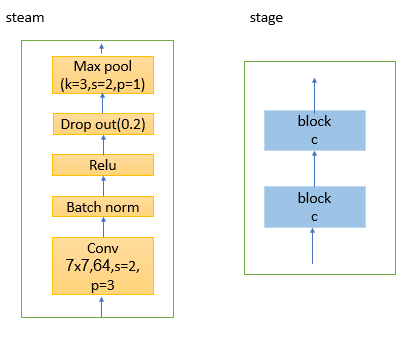

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [9]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange,dropping_prob= 0.2,hidden_size=512):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(p= dropping_prob),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    self.spatialEx = SpatialExchange()
    self.channelEx = ChannelExchange()

    self.stage1= self._make_stage(block,64,64)
    self.stage2= self._make_stage(block,64,128)
    self.stage3= self._make_stage(block,128,256)
    self.stage4= self._make_stage(block,256,512)

    self.adptive_avePool = nn.AdaptiveAvgPool2d((1,1))

    self.fc = nn.Sequential(
      nn.Linear(1024, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size,8),
      nn.Softmax(dim=1)
    )

  def _make_stage(self,block,in_ch,out_ch):
    block_1 = block(in_channelSize=in_ch,out_channelSize=in_ch)
    block_2 = block(in_channelSize=in_ch,out_channelSize=out_ch)
    layers = [block_1,block_2]
    return nn.Sequential(*layers)

  def forward(self,x1,x2):
    out1 , out2 = self.steam(x1) , self.steam(x2)
    out1 , out2 = self.stage1(out1) , self.stage1(out2)
    out1 , out2 = self.stage2(out1) , self.stage2(out2)
    out1 , out2 = self.spatialEx(out1 , out2)
    out1 , out2 = self.stage3(out1) , self.stage3(out2)
    out1 , out2 = self.channelEx(out1 , out2)
    out1 , out2 = self.stage4(out1) , self.stage4(out2)
    out1 , out2 = self.channelEx(out1 , out2)
    out = torch.cat((out1,out2),dim=1)
    out = self.adptive_avePool(out)
    out = out.view(out.size(0), -1)
    output = self.fc(out)

    return output

  ### when you are testing this model on colab, please set using_colab flag to 'True' and put .pth and the notebook files in the following path : "content/drive/My Drive/Colab Notebooks/", other wise just set the mentioned flag to 'False'.
  ## if you just wanna test the model please run first this cell and skip the two next cells and run the testing cell to get the results. other wise by running the next cells we just load the model and train it from the weights that it has now.

In [10]:
using_colab = True




device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
torch.cuda.empty_cache()

PATH = "model.pth"

if using_colab :
  from google.colab import drive
  drive.mount('/content/drive')
  GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive',"Colab Notebooks")
  print(os.listdir(GOOGLE_DRIVE_PATH))
  PATH = path.join(GOOGLE_DRIVE_PATH,"model.pth")

model=changer(block,SpatialExchange,ChannelExchange).to(device)
criterion =  nn.BCELoss()
optimizer= optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
loss = checkpoint['loss']

def multi_hot_accuracy(y_pred, y_true, threshold = 0.5):
    y_buffer  = torch.zeros(y_true.shape[0])
    y_pred_binary = (y_pred > threshold).float()

    for i , vec in enumerate(y_pred_binary) :
      y_buffer[i] = torch.max()

    return y_buffer.sum().item()

def decimal_to_one_hot(dec_vec, num_classes=8):
    one_hot = torch.zeros((len(dec_vec),num_classes)).to('cuda')
    for i , elem in enumerate(dec_vec) :
      one_hot[i][int(elem)] = 1
    return one_hot

Using cuda device
Mounted at /content/drive
['model.pth', 'detect_change.ipynb']


## Train & validation


In [ ]:
Loss_train=[]
loss_valid=[]
acc_train=[]
acc_valid=[]

def MyMax(data):
  output = torch.zeros_like(data)
  for i in range(data.shape[0]):
    output[i] = torch.max(data[i,:],1)

n_epochs = 15
patience = 4
min_delta = 0.01
best_valid_loss = float('inf')
counter = 0
torch.cuda.empty_cache()

for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    for i,(origin_img, changed_img, label_vecs , labels) in enumerate(tqdm(train_loader)):
        origin_img, changed_img, label_vecs , labels = origin_img.to(device), changed_img.to(device), label_vecs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(origin_img,changed_img)
        loss = criterion(outputs, decimal_to_one_hot(labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        # correct_train += multi_hot_accuracy(outputs.data,label_vecs)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        # print(f'epoch : {epoch} batch index : {i}')
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

    train_loss /= len(train_loader.dataset)
    Loss_train.append(train_loss)
    acc = correct_train/len(train_loader.dataset)
    acc_train.append(acc)
    print(f'Epoch: {epoch+1} \tloss_TRAIN ={train_loss:.3f},acc_train={acc:.3f}')
    # Validation
    model.eval()
    valid_loss = 0.0
    correct_valid = 0

    with torch.no_grad():
        for (origin_img, changed_img, label_vecs , labels) in tqdm(valid_loader):
          origin_img, changed_img, label_vecs , labels = origin_img.to(device), changed_img.to(device), label_vecs.to(device), labels.to(device)
          outputs = model(origin_img, changed_img)
          loss = criterion(outputs, decimal_to_one_hot(labels))
          valid_loss += loss.item() * labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct_valid += (predicted == labels).sum().item()
    valid_loss /= len(valid_loader.dataset)
    loss_valid.append(valid_loss)
    acc = correct_valid/len(valid_loader.dataset)
    acc_valid.append(acc)
    print(f'Epoch: {epoch+1}\t loss_val= {valid_loss:.3f}, acc_val={acc:.3f}')


100%|██████████| 632/632 [14:26<00:00,  1.37s/it]


Epoch: 1 	loss_TRAIN =0.274,acc_train=0.374


100%|██████████| 105/105 [01:03<00:00,  1.65it/s]


Epoch: 1	 loss_val= 1.044, acc_val=0.113


100%|██████████| 632/632 [14:26<00:00,  1.37s/it]


Epoch: 2 	loss_TRAIN =0.224,acc_train=0.488


100%|██████████| 105/105 [01:03<00:00,  1.65it/s]


Epoch: 2	 loss_val= 0.405, acc_val=0.200


100%|██████████| 632/632 [14:28<00:00,  1.37s/it]


Epoch: 3 	loss_TRAIN =0.209,acc_train=0.541


100%|██████████| 105/105 [01:04<00:00,  1.63it/s]


Epoch: 3	 loss_val= 0.420, acc_val=0.273


100%|██████████| 632/632 [14:31<00:00,  1.38s/it]


Epoch: 4 	loss_TRAIN =0.170,acc_train=0.669


100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch: 4	 loss_val= 0.316, acc_val=0.423


100%|██████████| 632/632 [14:29<00:00,  1.38s/it]


Epoch: 5 	loss_TRAIN =0.142,acc_train=0.732


100%|██████████| 105/105 [01:04<00:00,  1.64it/s]


Epoch: 5	 loss_val= 0.349, acc_val=0.395


100%|██████████| 632/632 [14:27<00:00,  1.37s/it]


Epoch: 6 	loss_TRAIN =0.132,acc_train=0.755


100%|██████████| 105/105 [01:04<00:00,  1.63it/s]


Epoch: 6	 loss_val= 0.440, acc_val=0.305


100%|██████████| 632/632 [14:26<00:00,  1.37s/it]


Epoch: 7 	loss_TRAIN =0.122,acc_train=0.777


100%|██████████| 105/105 [01:04<00:00,  1.63it/s]


Epoch: 7	 loss_val= 0.457, acc_val=0.350


100%|██████████| 632/632 [14:27<00:00,  1.37s/it]


Epoch: 8 	loss_TRAIN =0.114,acc_train=0.792


100%|██████████| 105/105 [01:05<00:00,  1.61it/s]


Epoch: 8	 loss_val= 0.304, acc_val=0.523


100%|██████████| 632/632 [14:27<00:00,  1.37s/it]


Epoch: 9 	loss_TRAIN =0.110,acc_train=0.801


100%|██████████| 105/105 [01:05<00:00,  1.61it/s]


Epoch: 9	 loss_val= 0.436, acc_val=0.364


100%|██████████| 632/632 [14:28<00:00,  1.37s/it]


Epoch: 10 	loss_TRAIN =0.107,acc_train=0.805


100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch: 10	 loss_val= 0.349, acc_val=0.390


100%|██████████| 632/632 [14:26<00:00,  1.37s/it]


Epoch: 11 	loss_TRAIN =0.107,acc_train=0.805


100%|██████████| 105/105 [01:04<00:00,  1.62it/s]


Epoch: 11	 loss_val= 0.279, acc_val=0.545


100%|██████████| 632/632 [14:25<00:00,  1.37s/it]


Epoch: 12 	loss_TRAIN =0.101,acc_train=0.815


100%|██████████| 105/105 [01:03<00:00,  1.65it/s]


Epoch: 12	 loss_val= 0.312, acc_val=0.561


100%|██████████| 632/632 [14:24<00:00,  1.37s/it]


Epoch: 13 	loss_TRAIN =0.098,acc_train=0.822


100%|██████████| 105/105 [01:03<00:00,  1.65it/s]


Epoch: 13	 loss_val= 0.266, acc_val=0.532


100%|██████████| 632/632 [14:27<00:00,  1.37s/it]


Epoch: 14 	loss_TRAIN =0.097,acc_train=0.823


100%|██████████| 105/105 [01:03<00:00,  1.66it/s]


Epoch: 14	 loss_val= 0.242, acc_val=0.575


100%|██████████| 632/632 [14:26<00:00,  1.37s/it]


Epoch: 15 	loss_TRAIN =0.093,acc_train=0.833


100%|██████████| 105/105 [01:03<00:00,  1.65it/s]

Epoch: 15	 loss_val= 0.364, acc_val=0.531


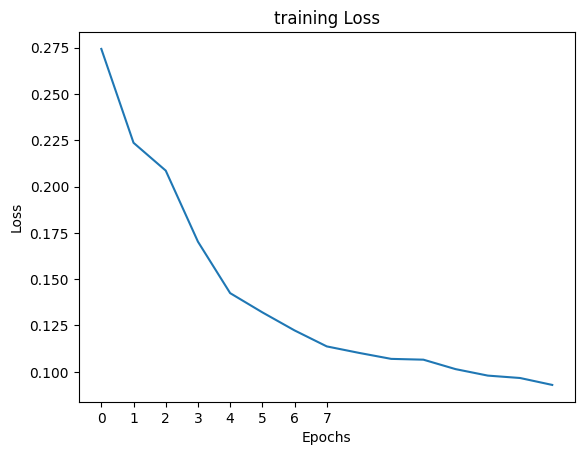

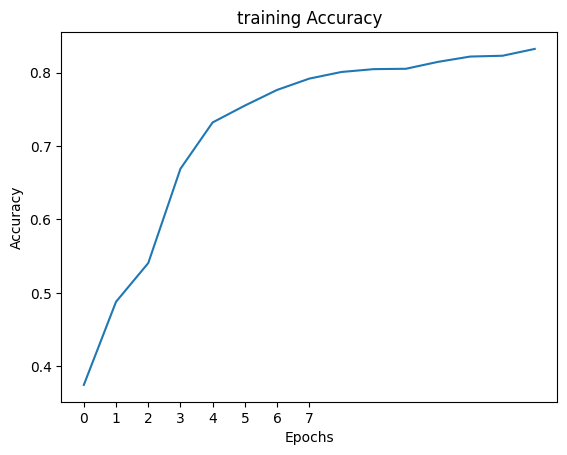

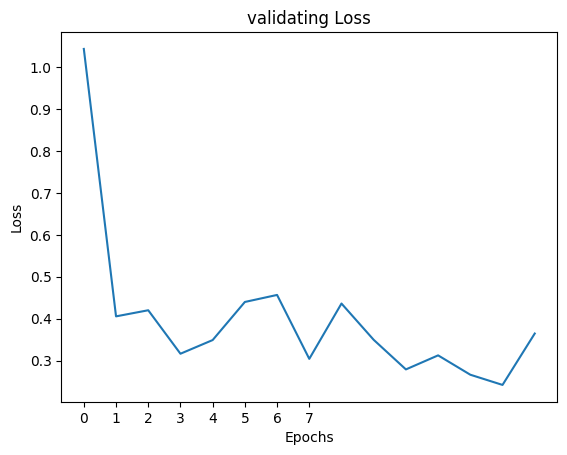

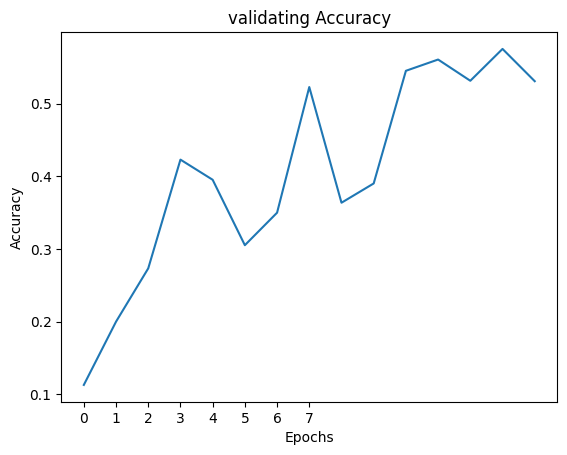

In [ ]:
def plot_eval(epoch_times, loss, accuracy , label):
  # Plotting
  plt.plot(loss)
  plt.xticks(epoch_times)
  plt.title(f'{label} Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(accuracy)
  plt.xticks(epoch_times)
  plt.title(f'{label} Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

plot_eval(range(8),Loss_train,acc_train,'training')
plot_eval(range(8),loss_valid,acc_valid,'validating')


# Test


In [12]:
def ModeCalcer(pred,label,dict_base):
   ref = torch.eq(pred,label)
   for i,elem in enumerate(ref):
    if elem.item() :
      if pred[i].item() == 1 or pred[i].item() == 2 or pred[i].item() == 4:
        dict_base[1] += 1
      if pred[i].item() == 3 or pred[i].item() == 5 or pred[i].item() == 6:
        dict_base[2] += 1
      else:
        dict_base[3] += 1
    else:
      if pred[i].item() == 1 or pred[i].item() == 2 or pred[i].item() == 4:
        dict_base[1] -= 1
      if pred[i].item() == 3 or pred[i].item() == 5 or pred[i].item() == 6:
        dict_base[2] -= 1
      else:
        dict_base[3] -= 1
   return dict_base

model = changer(block,SpatialExchange,ChannelExchange).to(device)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

dict_base = {1:0, 2:0, 3:0}
correct_test = 0
test_loss = 0
loss_test=[]
with torch.no_grad():
        for (origin_img, changed_img, label_vecs , labels) in tqdm(test_loader):
          origin_img, changed_img, label_vecs , labels = origin_img.to(device), changed_img.to(device), label_vecs.to(device), labels.to(device)
          outputs = model(origin_img, changed_img)
          loss = criterion(outputs, decimal_to_one_hot(labels))
          test_loss += loss.item() * labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct_test += (predicted == labels).sum().item()
          dict_base = ModeCalcer(labels.to('cpu'),labels.to('cpu'),dict_base)
test_loss /= len(test_loader.dataset)
acc = correct_test/len(test_loader.dataset)
print("\n")
print("""dict : \{1= one of the changes , 2 = two changes , 3 = all of the changes }""")
print(f"dict = {dict_base}")
print(f'loss_test= {test_loss:.3f}, acc_test={acc:.3f}')


100%|██████████| 63/63 [00:41<00:00,  1.53it/s]



dict : \{1= one of the changes , 2 = two changes , 3 = all of the changes \}
dict = {1: 957, 2: 874, 3: 1126}
loss_test= 0.090, acc_test=0.844


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟


---
به ترتیب حالات سه تغییره ، یک تغییره و دو تغییره بهتر تشخیص داده شده اند.